## LNN approach for learning dynamic for single pendulum

In [ ]:

import random
import os
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
from copy import copy
from utils import *

def fix_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ['PYTHONHASHSEED'] = str(seed)

fix_seed(42)


We have to generate data. We have the second-order differential equation that describes the motion of a simple pendulum:
\begin{equation}
\frac{d^2\theta}{dt^2} + \frac{g}{L} \sin \theta = 0
\end{equation}
We can transform this into a system of first-order equations by introducing the angular velocity $\omega = \frac{d\theta}{dt}$. This gives us:
\begin{align}
\frac{d\omega}{dt} &= -\frac{g}{L} \sin \theta \\
\frac{d\theta}{dt} &= \omega
\end{align}
Using the dot notation for time derivatives ($\dot{\theta} = \frac{d\theta}{dt}$ and $\dot{\omega} = \frac{d\omega}{dt}$), the system can also be written as:
\begin{align}
\dot{\theta} &= \omega \\
\dot{\omega} &= -\frac{g}{L} \sin \theta
\end{align}

We will use it and RK45 method for integration. RK45 is adaptive step-size Runge-Kutta method

In [211]:
L = 4
M = 2
G = 9.8
simulation_duration = 10

dt = .01
rk_integrator_args = {}
rk_integrator_args['rtol'] = 1e-13
rk_integrator_args['method'] = 'RK45'
rk_integrator_args['atol'] = 1e-10

odeint_integrator_args = {}
odeint_integrator_args['rtol'] = 1e-13
odeint_integrator_args['atol'] = 1e-10
odeint_integrator_args['full_output'] = 1

Generate training data with an initial angle of 80 degrees and zero angular velocity.

In [212]:
t_train = np.arange(0, simulation_duration, dt)
initial_pendulum_config = np.array([np.deg2rad(80), 0])
x_train_theta, train_joints_over_time, x_train = compute_thetas_over_time(simulation_duration, dt, initial_pendulum_config, rk_integrator_args, G, L)

Generate training data with an initial angle of 65 degrees and zero angular velocity. Train and test data is different to check generalizability

In [213]:
t_test = np.arange(0, simulation_duration, dt)
test_initial_pendulum_config = np.array([np.deg2rad(65),0])
x_test_theta ,test_joints_over_time,x_test = compute_thetas_over_time(simulation_duration, dt, test_initial_pendulum_config, rk_integrator_args, G, L)

Find true derivatives (in this appproach we will use only second derivative)

In [214]:
true_derivatives = []
for i in range(len(t_train)):
    true_derivatives.append(pendulum_motion(t_train[i], x_train.T[i], G, L))

true_derivatives=np.array(true_derivatives)

In paper, we stated that in order to satisfy Euler-
Lagrange equation:
\begin{equation}
\frac{d}{dt} \frac{\partial \mathcal{L}}{\partial \dot{q}_j} = \frac{\partial \mathcal{L}}{\partial q_j}
\end{equation}

We can using differentiation find second derivative like following.
\begin{equation}
\ddot{q} = \left( \nabla_{\dot{q}} \nabla_{\dot{q}}^\top \mathcal{L} \right)^{-1} \left[ \nabla_q \mathcal{L} - \left( \nabla_q \nabla_{\dot{q}}^\top \mathcal{L} \right) \dot{q} \right]
\end{equation}

However, in our case (a single pendulum), we have only one generalized coordinate $\theta$ and its first time derivative $\dot{\theta}$. Therefore, we can rewrite the equation as:
\begin{equation}
\ddot{\theta} = \left( \frac{\partial^2 \mathcal{L}}{\partial \dot{\theta}^2} \right)^{-1} \left[ \frac{\partial \mathcal{L}}{\partial \theta} - \left( \frac{\partial^2 \mathcal{L}}{\partial \theta \partial \dot{\theta}} \right) \dot{\theta} \right]
\end{equation}

This will gives us system that will satisfy Euler-
Lagrange equation.


In [215]:
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

class PendulumDataset(Dataset):
    def __init__(self, data, targets):
        self.inputs = torch.tensor(data.T, dtype=torch.float32)
        self.targets = torch.tensor(targets[:, 1], dtype=torch.float32).unsqueeze(1)

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        return self.inputs[idx], self.targets[idx]

class LagrangianNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 128),
            nn.Softplus(),
            nn.Linear(128, 128),
            nn.Softplus(),
            nn.Linear(128, 1)
        )

    def forward(self, x):
        return self.net(x)

    def get_lagrangian_derivatives(self, x):
        """Use input x to calculate first and second derivatives of lagrangian with respect to x"""
        x = x.clone().detach().requires_grad_(True)
        L = self.forward(x)

        dL_dx = torch.autograd.grad(L, x, grad_outputs=torch.ones_like(L), create_graph=True)[0]
        dL_dtheta = dL_dx[:, 0:1]
        dL_domega = dL_dx[:, 1:2]

        d2L_domega2 = torch.autograd.grad(dL_domega, x, grad_outputs=torch.ones_like(dL_domega), create_graph=True)[0][:, 1:2]
        d2L_dtheta_domega = torch.autograd.grad(dL_dtheta, x, grad_outputs=torch.ones_like(dL_dtheta), create_graph=True)[0][:, 1:2]

        return d2L_domega2, dL_dtheta, d2L_dtheta_domega

    def lagrangian_dynamics_hessian(self, x):
        """For given input x, calculate ddot_theta using derivatives of learned lagrangian"""
        d2L_domega2, dL_dtheta, d2L_dtheta_domega = self.get_lagrangian_derivatives(x)
        omega = x[:, 1:2]
        ddot_theta = (dL_dtheta - d2L_dtheta_domega * omega) / d2L_domega2
        return ddot_theta

    def train_lnn_hessian(self, dataloader, epochs=1000, lr=0.001):
        """Train LNN model"""
        optimizer = optim.Adam(self.parameters(), lr=lr)
        criterion = nn.MSELoss()
        loss_history = []

        for epoch in range(epochs):
            total_loss = 0
            for x_batch, y_batch in dataloader:
                optimizer.zero_grad()
                predicted_ddot = self.lagrangian_dynamics_hessian(x_batch)
                loss = criterion(predicted_ddot, y_batch)
                loss.backward()
                optimizer.step()
                total_loss += loss.item() * len(x_batch)

            avg_loss = total_loss / len(dataloader.dataset)
            loss_history.append(avg_loss)
            if epoch % 10 == 0:
                print(f"Epoch {epoch}/{epochs}, Loss: {avg_loss:.6f}")
        return loss_history


Epoch 0/100, Loss: 1.194103
Epoch 10/100, Loss: 0.000565
Epoch 20/100, Loss: 0.000259
Epoch 30/100, Loss: 0.000259
Epoch 40/100, Loss: 0.000199
Epoch 50/100, Loss: 0.000126
Epoch 60/100, Loss: 0.000334
Epoch 70/100, Loss: 0.000130
Epoch 80/100, Loss: 0.000106
Epoch 90/100, Loss: 0.000286


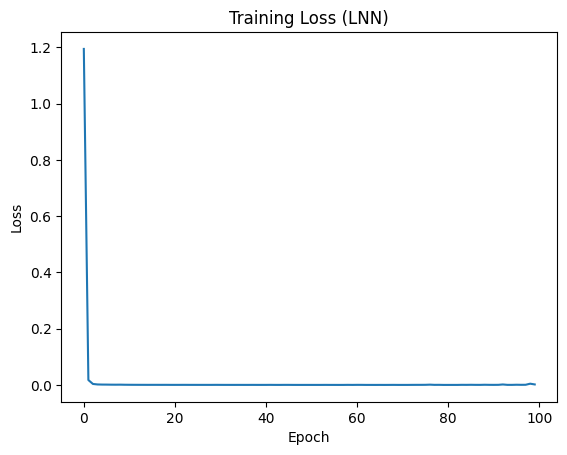

In [216]:
dataset = PendulumDataset(x_train, true_derivatives)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

lnn_model = LagrangianNN()
loss = lnn_model.train_lnn_hessian(dataloader, epochs=100, lr=0.0005)

plt.plot(range(len(loss)), loss)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss (LNN)")
plt.show()


In [217]:
def learned_pendulum_dynamics(y, t, model):
    """Use learned differential equation"""
    y_tensor = torch.tensor(y, dtype=torch.float32).unsqueeze(0)
    ddot_theta = model.lagrangian_dynamics_hessian(y_tensor).squeeze().item()
    return [y[1], ddot_theta]


Integrating to find θ at each time step, we use the odeint integrator, which adapts the method to the stiffness of the ODE. It is also the default choice for SINDy.

In [218]:
from scipy.integrate import odeint
test_initial_pendulum_config = np.array([np.deg2rad(65), 0.0])
t = np.arange(0, simulation_duration, 0.01)
solution = odeint(learned_pendulum_dynamics, test_initial_pendulum_config, t, args=(lnn_model,))


Visualize theta acceleration

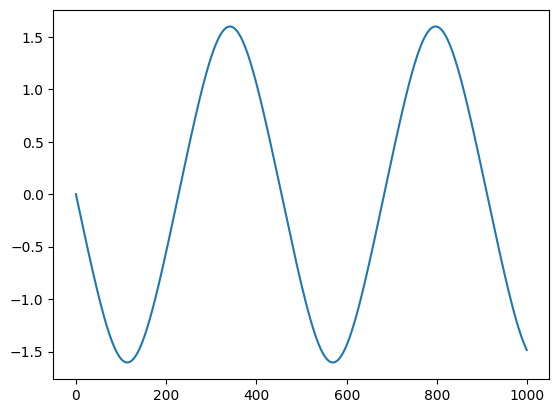

In [219]:
plt.plot(range(len(solution[:, 1])), solution[:, 1])

Make visualization of learned dynamic and save into file

In [220]:
informed_simulation = solution.T
informed_simulation[0] = loop_around_angles(informed_simulation[0])
joints_over_time_informed = compute_joints_position(informed_simulation[0], L)

In [221]:
animate_pendulum_versus(test_joints_over_time, joints_over_time_informed,"our_informed_single_pendulum.mp4", interval=0.003, fps=240)